## Investigate the effects of an inside and outside neighbour on greyhound run speed

It appears that having an inside/outside neighbour affects the run speed of a greyhound (higher speeds given a lack of neighbours) - It's also interesting to note that not having an inside neighbour is more valuable than not having an outside neighbour.

It's also interesting to note that based on the (Track, Dist), the value of not having an inside or outside neighbour changes dramatically. 

----

### 0. Read cleansed data

In [1]:
import os
import decouple
config = decouple.AutoConfig(' ')
os.chdir(config('ROOT_DIRECTORY'))
import sys
sys.path.insert(0, '')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import zscore

pd.set_option('display.max_columns', None)

# Read in data
df_raw = pd.read_csv('./data/clean/dog_results.csv')

display(df_raw)

,FasttrackDogId,Place,DogName,Box,Rug,Weight,StartPrice,Margin1,Margin2,PIR,Checks,SplitMargin,RunTime,Prizemoney,FasttrackRaceId,TrainerId,TrainerName,Distance,RaceGrade,Track,RaceNum,TrackDist,RaceDate
0,157500927,1,RAINE ALLEN,1,1,27.4,2.4,2.30,NaN,Q/111,0,6.68,28.66,0.0,335811282,7683,C GRENFELL,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01
1,1820620018,2,SURF A LOT,2,2,32.8,6.3,2.30,2.30,M/332,0,7.01,28.82,0.0,335811282,137227,C TYLEY,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01
2,1950680026,3,PINGIN' BEE,6,6,25.5,9.3,3.84,1.54,S/443,0,7.24,28.93,0.0,335811282,132763,P DAPIRAN,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01
3,1524380048,4,LUCAS THE GREAT,7,7,32.2,9.1,5.27,1.43,M/655,5,7.31,29.03,0.0,335811282,116605,E HAMILTON,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01
4,124225458,5,QUAVO,4,4,28.9,3.4,5.56,0.29,M/766,8,7.38,29.05,0.0,335811282,132763,P DAPIRAN,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763162,614057722,4,INFAMOUS ANGEL,3,3,25.0,NaN,12.25,0.14,2,0,7.10,18.45,0.0,734778635,69407,P WORTHINGTON,302,Qualifying Trial,Mandurah,2,Mandurah302,2021-11-30
763163,576142623,1,ROISIN MONELLI,1,1,29.1,NaN,1.00,NaN,11,0,6.73,23.43,0.0,734778636,130513,D HOBBY,405,Qualifying Trial,Mandurah,3,Mandurah405,2021-11-30
763164,540582677,2,RAPIDO CHA CHA,7,7,26.1,NaN,1.00,1.14,32,0,6.92,23.51,0.0,734778636,130351,R WESTWORTH,405,Qualifying Trial,Mandurah,3,Mandurah405,2021-11-30
763165,580792922,3,TIGGERLONG FOOT,5,5,25.5,NaN,6.00,4.86,23,0,6.89,23.85,0.0,734778636,102994,S BEARD,405,Qualifying Trial,Mandurah,3,Mandurah405,2021-11-30


### 1. Create necessary columns for analysis

In [4]:
# Copy raw dataframe
df = df_raw.copy()

# Determine for each dog whether there is an inside or outside neighbour (0=no, 1=yes)
df = df.sort_values(by=["RaceDate", "FasttrackRaceId", "Box"])
df["InsideNeighbour"] = (df.groupby(["FasttrackRaceId"])["Box"].transform(lambda x: x.diff()).fillna(0) == 1).astype(int)
df["OutsideNeighbour"] = (df.groupby(["FasttrackRaceId"])["Box"].transform(lambda x: abs(x.diff(-1))).fillna(0) == 1).astype(int)

# Determine the inside and outside boxes for each race (for example, if box 1 is scratched then box 2 becomes the inside box)
df["InsideBox"] = df.groupby(["FasttrackRaceId"])["Box"].transform(lambda x: x == min(x))
df["OutsideBox"] = df.groupby(["FasttrackRaceId"])["Box"].transform(lambda x: x == max(x))

# Calculate the speed of each dog for each race
df["Speed"] = df["Distance"]/df["RunTime"]

# Normalise each greyhounds speed by TrackDist
df["SpeedNorm"] = df.groupby("TrackDist")["Speed"].transform(lambda x: zscore(x, nan_policy='omit'))

display(df)

,FasttrackDogId,Place,DogName,Box,Rug,Weight,StartPrice,Margin1,Margin2,PIR,Checks,SplitMargin,RunTime,Prizemoney,FasttrackRaceId,TrainerId,TrainerName,Distance,RaceGrade,Track,RaceNum,TrackDist,RaceDate,InsideNeighbour,OutsideNeighbour,InsideBox,OutsideBox,Speed,SpeedNorm
201,196374475,5,LAYBACK CRUISER,1,1,32.1,4.0,3.67,1.59,M/123,1,5.32,25.60,0.0,334309830,67940,J GRIMA,440,Mixed 6/7 Final,Sale,4,Sale440,2018-07-01,0,1,True,False,17.187500,-0.068228
197,119991023,1,EMPTY CHAMBER,2,2,31.6,18.1,1.44,NaN,S/744,0,5.55,25.35,0.0,334309830,105986,D DEAN,440,Mixed 6/7 Final,Sale,4,Sale440,2018-07-01,1,1,False,False,17.357002,0.574128
200,160105572,4,HEAD LOCH,3,3,33.6,3.2,2.09,0.17,M/511,2,5.40,25.49,0.0,334309830,110650,R CLARK,440,Mixed 6/7 Final,Sale,4,Sale440,2018-07-01,1,1,False,False,17.261671,0.212857
199,184224214,3,MAVERICK TYPHOON,4,4,32.7,7.8,1.91,0.47,M/355,5,5.36,25.48,0.0,334309830,58389,M CARTECHINI,440,Mixed 6/7 Final,Sale,4,Sale440,2018-07-01,1,1,False,False,17.268446,0.238530
203,131736468,7,URBAN SHIRAZ,5,5,24.6,12.4,6.53,0.39,M/466,8,5.39,25.80,0.0,334309830,67436,G SCIORTINO,440,Mixed 6/7 Final,Sale,4,Sale440,2018-07-01,1,1,False,False,17.054264,-0.573150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762491,438202679,6,DAINTY LEIGH,2,2,28.3,53.7,11.10,1.06,S/543,1,6.70,26.59,0.0,735164905,123078,S TONER,460,Maiden,Warragul,1,Warragul460,2021-11-30,1,1,False,False,17.299737,-0.156369
762490,536729322,5,MAGIC CHANGES,3,3,27.3,4.5,10.04,3.06,M/356,4,6.69,26.52,0.0,735164905,132537,R CUNNINGHAM,460,Maiden,Warragul,1,Warragul460,2021-11-30,1,0,False,False,17.345400,0.021982
762488,550747962,3,NIGHT PATROL,5,5,34.0,23.1,5.73,4.34,M/665,8,6.84,26.22,0.0,735164905,125087,R CONWAY,460,Maiden,Warragul,1,Warragul460,2021-11-30,0,1,False,False,17.543860,0.797130
762489,524412240,4,SIR MARLEY,6,6,33.1,12.4,6.99,1.26,M/434,0,6.70,26.30,0.0,735164905,132674,D CRAWFORD,460,Maiden,Warragul,1,Warragul460,2021-11-30,1,0,False,False,17.490494,0.588695


### 2. Analyse average SpeedNorm w.r.t inside and outside neighbour 

We determine the statistics for each sample group, these can also be used to calculate a p-value. We remove the inside boxes when comparing inside neighbour (since the inside box never has an inside neighbour), similary we do the same for outside boxes.

In [7]:
'''
Inside neighbour
'''

df_temp = df.copy()

# Take all boxes except for the inside box
df_temp = df_temp[df_temp["InsideBox"] == False]
df_temp = df_temp[["Box", "InsideNeighbour", "SpeedNorm"]]
df_temp = df_temp.groupby(["InsideNeighbour"], as_index=False).agg({"SpeedNorm": [np.mean, np.std, np.size]})

display(df_temp)

'''
Outside neighbour
'''

df_temp = df.copy()

# Take all boxes except for the outside box
df_temp = df_temp[df_temp["OutsideBox"] == False]
df_temp = df_temp[["Box", "InsideNeighbour", "OutsideNeighbour", "SpeedNorm"]]
df_temp = df_temp.groupby(["OutsideNeighbour"], as_index=False).agg({"SpeedNorm": [np.mean, np.std, np.size]})

display(df_temp)

InsideNeighbour SpeedNorm                    
                       mean       std      size
0               0  0.051256  1.004694   71293.0
1               1 -0.029878  0.996528  584932.0

OutsideNeighbour SpeedNorm                    
                        mean       std      size
0                0  0.072137  1.019713   71293.0
1                1 -0.013080  1.000798  584932.0

We similarly plot the average SpeedNorm for different TrackDist values that have a sample size larger than 2500

<AxesSubplot:xlabel='InsideNeighbour', ylabel='SpeedNorm_mean'>

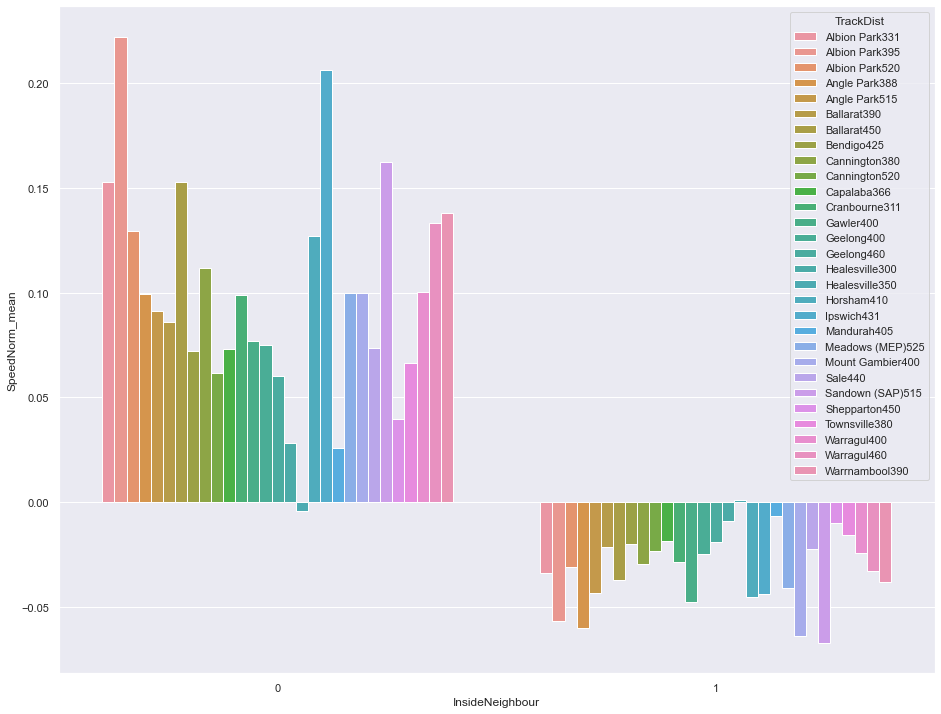

In [10]:
# Copy dataframe
df_temp = df.copy()

# Groupby TrackDist, aggregate average SpeedNorm and sample size
df_temp = df_temp.groupby(["TrackDist", "InsideNeighbour"], as_index=False).agg(SpeedNorm_mean=('SpeedNorm', 'mean'),
                                                                                SampleSize=('SpeedNorm', 'count'))

# Take only TrackDist with a large enough sample size (>=2500)
df_temp["MinSampleSize"] = df_temp.groupby("TrackDist")["SampleSize"].transform(lambda x: min(x))
df_temp = df_temp[df_temp["MinSampleSize"] >= 2500]

# Plot
sns.set_theme()
fig, ax = plt.subplots(figsize=(15.7, 12.27))
plt.rc('xtick',labelsize=15)
plt.rcParams["axes.labelsize"] = 15
plt.rc('ytick',labelsize=15)

sns.barplot(data=df_temp, x="InsideNeighbour", y="SpeedNorm_mean", hue="TrackDist")

Similarly for outside neighbours

<AxesSubplot:xlabel='OutsideNeighbour', ylabel='SpeedNorm_mean'>

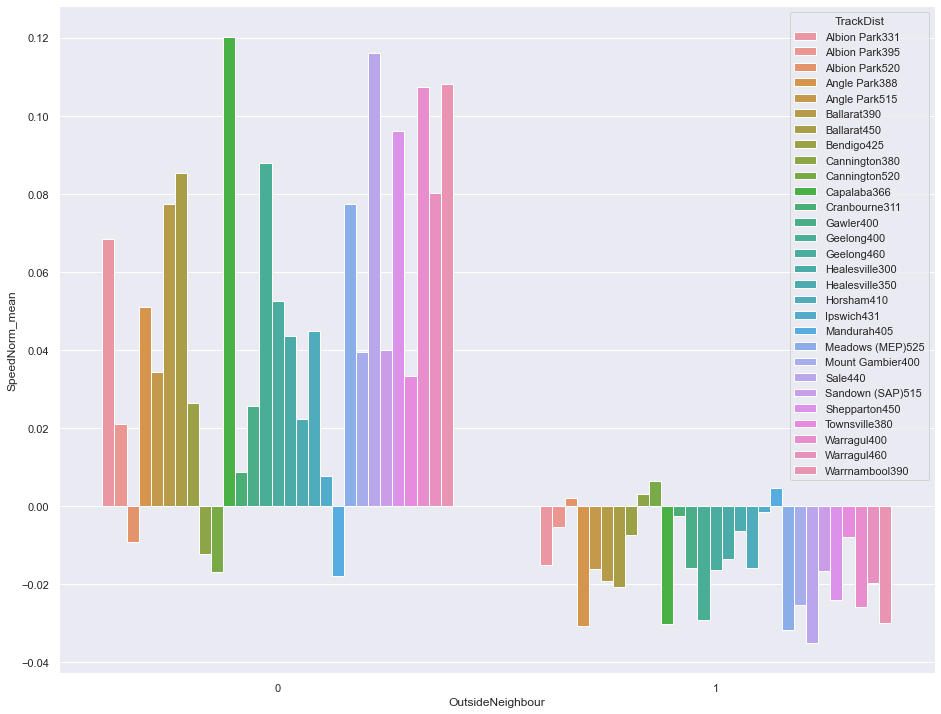

In [11]:
# Copy dataframe
df_temp = df.copy()

# Groupby TrackDist, aggregate average SpeedNorm and sample size
df_temp = df_temp.groupby(["TrackDist", "OutsideNeighbour"], as_index=False).agg(SpeedNorm_mean=('SpeedNorm', 'mean'),
                                                                                 SampleSize=('SpeedNorm', 'count'))

# Take only TrackDist with a large enough sample size (>=2500)
df_temp["MinSampleSize"] = df_temp.groupby("TrackDist")["SampleSize"].transform(lambda x: min(x))
df_temp = df_temp[df_temp["MinSampleSize"] >= 2500]

# Plot
sns.set_theme()
fig, ax = plt.subplots(figsize=(15.7, 12.27))
plt.rc('xtick',labelsize=15)
plt.rcParams["axes.labelsize"] = 15
plt.rc('ytick',labelsize=15)

sns.barplot(data=df_temp, x="OutsideNeighbour", y="SpeedNorm_mean", hue="TrackDist")